In [46]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("..")

from llama_index.llms.openai import OpenAI
from src.local_models.embeddings import get_embed_model

from src.data_loader.load_files import load_data
from src.data_loader.chunking import chunk_docs_standalone

from src.data_loader.load_from_dir import rebuild_index

from src.nebula_graph.nebula_operations import show_hosts, add_hosts_if_not_available, show_spaces, init_nebula_cluster
from src.nebula_graph.text_2_graph import df_to_fig, extract_triplets, get_response_n_kg_rel_query, get_response_n_kg_rel_chat

#from llama_index.core import Document
import os, re, ast

from dotenv import load_dotenv

In [2]:
from llama_index.graph_stores.nebula import NebulaGraphStore
from llama_index.core import KnowledgeGraphIndex, VectorStoreIndex, SimpleDirectoryReader

from llama_index.core.response_synthesizers import get_response_synthesizer
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import PromptTemplate


In [9]:
load_dotenv(override=True)

True

In [16]:
embed_model = get_embed_model(model_name=os.environ['embed_path'],  model_kwargs={'device': 'cpu'}, encode_kwargs = {'normalize_embeddings': True})
llm = OpenAI()

In [48]:
add_hosts_if_not_available()
space_name = "nfdw"

init_nebula_cluster(space_name)

edge_types, rel_prop_names = ["relationship"], ["relationship"] # default, could be omit if create from an empty kg
tags = ["entity"]

graph_store = NebulaGraphStore(
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags,
)

In [66]:
#first-time build
#第二部分only
documents = load_data(os.environ['data_path'])[2]
nodes = [chunk_docs_standalone(documents, chunk_size=512, chunk_overlap=50)][0]

kg_index = KnowledgeGraphIndex(
    nodes,
    max_triplets_per_chunk=10,
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags,
)



Parsing nodes: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


In [67]:
kg_index.storage_context.persist(persist_dir="../db_stores/kg_index")

In [24]:
kg_index = rebuild_index('../db_stores/kg_index')

In [74]:
kg_rag_query_engine = kg_index.as_query_engine(
    include_text=True,
    retriever_mode="hybrid",
    response_mode="tree_summarize",
)


In [75]:
response = kg_rag_query_engine.query("常规作业有哪些")
#常规作业有哪些


In [81]:
#response.source_nodes[0].text


In [76]:
resp, kg_rel_texts = get_response_n_kg_rel_query(response)
kg_rel_texts

["['单一类型作业', '包括', '发电机和高压电动机作业']", "['常规作业', '包括', '单一类型作业']"]

In [71]:
extracted_triplets = extract_triplets(kg_rel_texts)
extracted_triplets

,e1,r,e2
0,单一类型作业,包括,发电机和高压电动机作业
1,常规作业,包括,单一类型作业


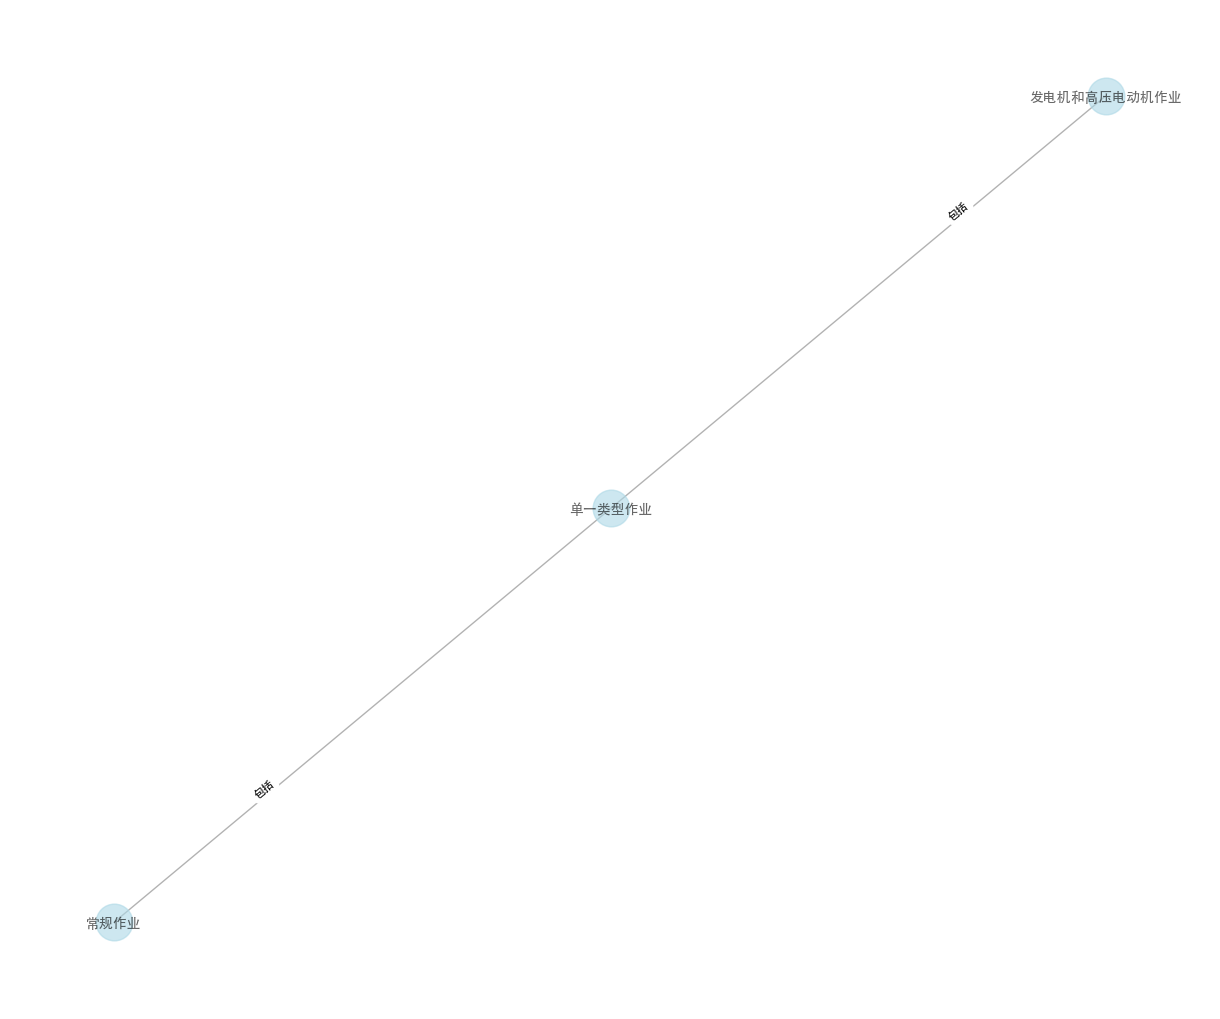

In [72]:
kg_fig = df_to_fig(extracted_triplets, show_fig=True)